### Importing Libraries

In [2]:
''' Here we shall import all the necessary libraries and functions that we will be using during the tasks. '''

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

### Device

In [5]:
''' We decide which device - CPU or GPU - to use for the training purposes. '''

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


### Load Data

In [ ]:
''' In this lab, we shall use CIFAR100 dataset which is an image classification dataset with 100 classes. '''

In [8]:
%cd E:/torchvision/datasets/data

E:\torchvision\datasets\data


In [10]:
# Load CIFAR-100 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = torchvision.datasets.CIFAR100(root='.', train=True, download=False, transform=transform)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False, num_workers=2)

test_data = torchvision.datasets.CIFAR100(root='.', train=False, download=False, transform=transform)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=2)

In [11]:
# Checking the shape of the input 

print("Train data")
print(len(train_data))   # length of the train data
for batch in train_loader:
    images, labels = batch
    print(images.shape)     # shape of the images
    print(labels.shape)     # shape of the labels
    break

print("\nValidation data")
print(len(val_data))
for batch in val_loader:
    images, labels = batch
    print(images.shape)
    print(labels.shape)
    break

print("\nTest data")
print(len(test_data))
for batch in test_loader:
    images, labels = batch
    print(images.shape)
    print(labels.shape)
    break

Train data
40000
torch.Size([64, 3, 32, 32])
torch.Size([64])

Validation data
10000
torch.Size([64, 3, 32, 32])
torch.Size([64])

Test data
10000
torch.Size([64, 3, 32, 32])
torch.Size([64])


### Hyperparameters

In [4]:
''' We define all the necessary training hyperparameters such as batch_size, number of epochs, learning rate, etc. '''

' We define all the necessary training hyperparameters such as batch_size, number of epochs, learning rate, etc. '

In [12]:
seed = 42   # for reproducibility
torch.manual_seed(seed)     # set seed for torch
torch.backends.cudnn.benchmark = False 
torch.backends.cudnn.deterministic = True 
batch_size = 64
epochs = 10 
learning_rate = 0.005

## With Dense Block Connections

In [ ]:
''' In this part of the assignment, we use a DenseNet architecture with 3 Convolutional blocks and 3 Dense blocks between. This is a smaller version of the original DenseNet architecture. 
Between each pair of consecutive dense blocks, a transition block is used to reduce the number of feature-maps. We have used AvgPooling in the transition block. 
In the output layer, we use a Dense layer with 100 output units, as we have 100 classes in the CIFAR100 dataset. '''

### Model Architecture

In [6]:
class DenseBlock(nn.Module):
    
    def __init__(self, in_channels, growth_rate, num_layers):
        super(DenseBlock, self).__init__()
        self.layers = nn.ModuleList([self._make_layer(in_channels + i * growth_rate, growth_rate) for i in range(num_layers)])

    def _make_layer(self, in_channels, growth_rate):
        return nn.Sequential(
            nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        features = [x]
        for layer in self.layers:
            features.append(layer(torch.cat(features, 1)))
        return torch.cat(features, 1)

In [7]:
class TransitionBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(TransitionBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        return self.pool(self.conv(x))

In [8]:
class DenseNet(nn.Module):

    def __init__(self, growth_rate=12, block_config=(16, 16, 16), num_classes=100):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate
        self.features = nn.Sequential(
            nn.Conv2d(3, 2*growth_rate, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        num_features = 2*growth_rate

        for i in range(len(block_config)):
            num_layers = block_config[i]
            block = DenseBlock(num_features, growth_rate, num_layers)
            self.features.add_module(f'dense_block_{i}', block)

            num_features += num_layers * growth_rate

            if i != len(block_config) - 1:
                trans = TransitionBlock(num_features, num_features // 2)
                self.features.add_module(f'transition_{i}', trans)
                num_features = num_features // 2


        self.classifier = nn.Linear(num_features, num_classes)

    def forward(self, x):
        features = self.features(x)
        out = torch.nn.functional.adaptive_avg_pool2d(features, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

### Training loop

In [13]:
model = DenseNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [14]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):

    model.train()
    running_loss = 0.0
    all_predictions = []
    all_targets = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())
    
    loss = running_loss / len(train_loader.dataset)
    accuracy = accuracy_score(all_targets, all_predictions)

    return loss, accuracy


In [15]:
def validate_one_epoch(model, val_loader, criterion, device):

    model.eval()
    running_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(val_loader.dataset)
    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions, average='weighted')
    recall = recall_score(all_targets, all_predictions, average='weighted')
    f1 = f1_score(all_targets, all_predictions, average='weighted')
    
    return avg_loss, accuracy, precision, recall, f1

In [16]:
# TRAINING

all_train_acc = []
all_train_loss = []
all_val_acc = []
all_val_loss = []
all_prec = []
all_rec = []
all_f1 = []

for epoch in range(epochs):

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy, precision, recall, f1 = validate_one_epoch(model, val_loader, criterion, device)

    all_train_loss.append(train_loss)
    all_train_acc.append(train_acc)
    all_val_loss.append(val_loss)
    all_val_acc.append(val_accuracy)
    all_prec.append(precision)
    all_rec.append(recall)
    all_f1.append(f1)
    
    print(f"Epoch {epoch+1}") 
    print("Train Loss:", train_loss)
    print("Train accuracy:", train_acc)
    print("Validation Loss:", val_loss) 
    print("Validation Accuracy:", val_accuracy) 
    print("Precision:", precision)
    print("Recall:", recall) 
    print("F1 Score:", f1,"\n")


Epoch 1
Train Loss: 4.165377048873902
Train accuracy: 0.0572
Validation Loss: 3.8207279739379882
Validation Accuracy: 0.0988
Precision: 0.09746566058035025
Recall: 0.0988
F1 Score: 0.07450741978479382 

Epoch 2
Train Loss: 3.6563009483337403
Train accuracy: 0.136125
Validation Loss: 3.4887326416015627
Validation Accuracy: 0.1625
Precision: 0.19849966516971457
Recall: 0.1625
F1 Score: 0.13337884111190612 

Epoch 3
Train Loss: 3.354288667678833
Train accuracy: 0.18775
Validation Loss: 3.2965556632995607
Validation Accuracy: 0.2068
Precision: 0.2521214694879146
Recall: 0.2068
F1 Score: 0.18591302814286395 

Epoch 4
Train Loss: 3.163005322647095
Train accuracy: 0.2281
Validation Loss: 3.1656876609802245
Validation Accuracy: 0.2274
Precision: 0.26296909964269616
Recall: 0.2274
F1 Score: 0.20651433275448966 

Epoch 5
Train Loss: 2.9876484577178957
Train accuracy: 0.2601
Validation Loss: 2.981596073913574
Validation Accuracy: 0.2656
Precision: 0.2978208523256654
Recall: 0.2656
F1 Score: 0.249

In [20]:
import pickle
pickle.dump(model, open('DenseNet.pkl', 'wb'))

### Loss curves

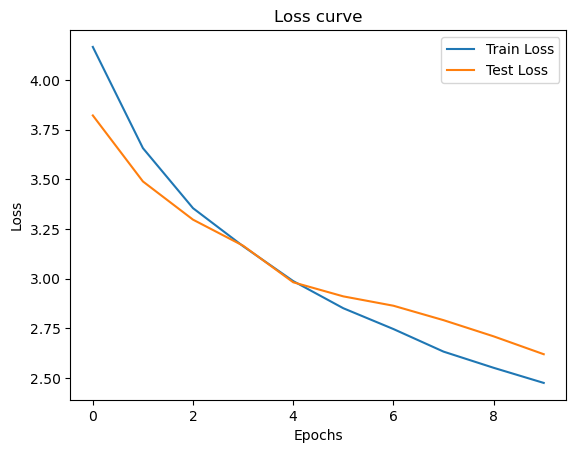

In [17]:
import matplotlib.pyplot as plt
plt.plot(all_train_loss, label='Train Loss')
plt.plot(all_val_loss, label='Test Loss')
plt.title("Loss curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Accuracy curves

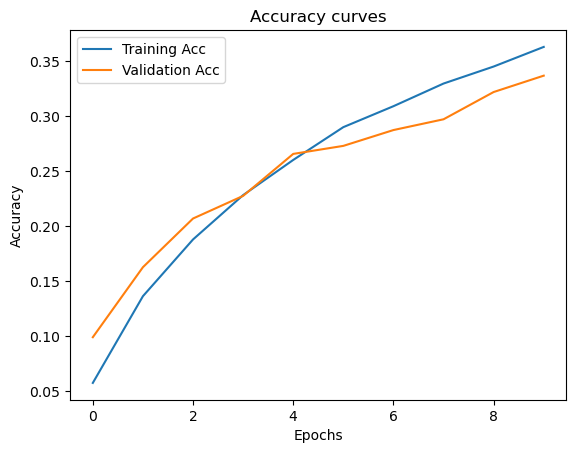

In [18]:
plt.plot(all_train_acc, label='Training Acc')
plt.plot(all_val_acc, label='Validation Acc')
plt.title("Accuracy curves")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Testing

In [22]:
from sklearn.metrics import classification_report

model.eval()
running_loss = 0.0
all_predictions = []
all_targets = []

with torch.no_grad():
    
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

print("Testing loss =", running_loss / len(val_loader.dataset),"\n")

print(classification_report(all_targets, all_predictions))

Testing loss = 2.6197821712493896 

              precision    recall  f1-score   support

           0       0.44      0.57      0.50       107
           1       0.37      0.49      0.42       107
           2       0.11      0.34      0.17        88
           3       0.19      0.10      0.13       103
           4       0.11      0.10      0.10        93
           5       0.25      0.51      0.33       105
           6       0.27      0.29      0.28        93
           7       0.16      0.31      0.21        96
           8       0.45      0.28      0.34        87
           9       0.60      0.39      0.47        88
          10       0.31      0.19      0.24       100
          11       0.26      0.09      0.13       100
          12       0.60      0.24      0.35        99
          13       0.50      0.16      0.25        86
          14       0.31      0.08      0.13       100
          15       0.33      0.24      0.28        87
          16       0.48      0.31      0.38  

## Without Dense Connections

In [13]:
''' In this part of the assignment, we use a DenseNet architecture with 3 Convolutional blocks. Here we remove the Dense blocks and use only the transition blocks.
We have used AvgPooling in the transition block. In the output layer, we use a Dense layer with 100 output units, as we have 100 classes in the CIFAR100 dataset. '''

' In this part of the assignment, we use a DenseNet architecture with 3 Convolutional blocks. Here we remove the Dense blocks and use only the transition blocks.\nWe have used AvgPooling in the transition block. In the output layer, we use a Dense layer with 100 output units, as we have 100 classes in the CIFAR100 dataset. '

### Model Architecture

In [20]:
class DenseNetWithoutDense(nn.Module):
    def __init__(self, growth_rate=12, block_config=(16, 16, 16), num_classes=100):
        super(DenseNetWithoutDense, self).__init__()
        self.growth_rate = growth_rate

        self.features = nn.Sequential(
            nn.Conv2d(3, 2 * growth_rate, kernel_size=3, padding=1),
            nn.BatchNorm2d(2 * growth_rate),
            nn.ReLU(inplace=True)
        )

        num_features = 2 * growth_rate
        for i, num_layers in enumerate(block_config):
            block = self._make_block(num_features, growth_rate, num_layers)
            self.features.add_module(f'block_{i}', block)
            num_features += num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = TransitionBlock2(num_features, num_features // 2)
                self.features.add_module(f'transition_{i}', trans)
                num_features = num_features // 2

        self.classifier = nn.Linear(num_features, num_classes)

    def forward(self, x):
        features = self.features(x)
        out = torch.nn.functional.adaptive_avg_pool2d(features, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

    def _make_block(self, in_channels, growth_rate, num_layers):
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Sequential(
                nn.BatchNorm2d(in_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1)
            ))
            in_channels += growth_rate
        return nn.Sequential(*layers)

In [21]:
class TransitionBlock2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionBlock2, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(out_channels)  
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)  
        return self.pool(F.relu(x))

### Training loop

In [22]:
model = DenseNetWithoutDense().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [23]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):

    model.train()
    running_loss = 0.0
    all_predictions = []
    all_targets = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())
    
    loss = running_loss / len(train_loader.dataset)
    accuracy = accuracy_score(all_targets, all_predictions)

    return loss, accuracy


In [24]:
def validate_one_epoch(model, val_loader, criterion, device):

    model.eval()
    running_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()*inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(val_loader.dataset)
    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions, average='weighted')
    recall = recall_score(all_targets, all_predictions, average='weighted')
    f1 = f1_score(all_targets, all_predictions, average='weighted')
    
    return avg_loss, accuracy, precision, recall, f1

In [ ]:
# TRAINING

all_train_acc = []
all_train_loss = []
all_val_acc = []
all_val_loss = []
all_prec = []
all_rec = []
all_f1 = []

for epoch in range(10):

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy, precision, recall, f1 = validate_one_epoch(model, val_loader, criterion, device)

    all_train_loss.append(train_loss)
    all_train_acc.append(train_acc)
    all_val_loss.append(val_loss)
    all_val_acc.append(val_accuracy)
    all_prec.append(precision)
    all_rec.append(recall)
    all_f1.append(f1)
    
    print(f"Epoch {epoch+1}") 
    print("Train Loss:", train_loss)
    print("Train accuracy:", train_acc)
    print("Validation Loss:", val_loss) 
    print("Validation Accuracy:", val_accuracy) 
    print("Precision:", precision)
    print("Recall:", recall) 
    print("F1 Score:", f1,"\n")


In [ ]:
import pickle
pickle.dump(model, open('DenseNetWithoutDense.pkl', 'wb'))

### Loss curves

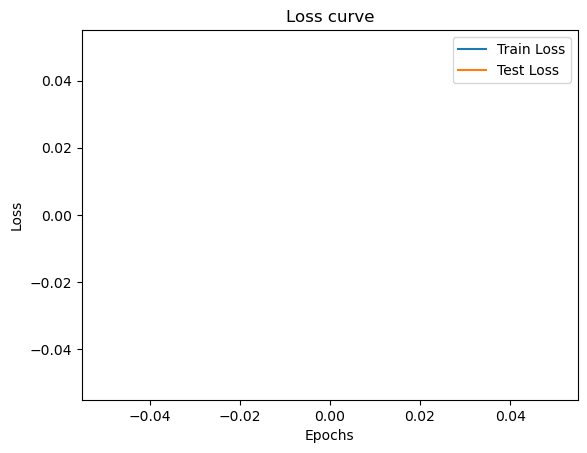

In [ ]:
import matplotlib.pyplot as plt
plt.plot(all_train_loss, label='Train Loss')
plt.plot(all_val_loss, label='Test Loss')
plt.title("Loss curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Accuracy curves

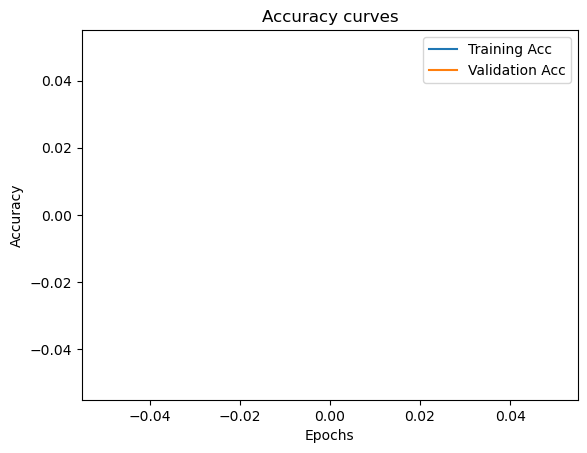

In [ ]:
plt.plot(all_train_acc, label='Training Acc')
plt.plot(all_val_acc, label='Validation Acc')
plt.title("Accuracy curves")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Testing

In [ ]:
from sklearn.metrics import classification_report

model.eval()
running_loss = 0.0
all_predictions = []
all_targets = []

with torch.no_grad():
    
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

print("Testing loss =", running_loss / len(val_loader.dataset),"\n")

print(classification_report(all_targets, all_predictions))